# Lab 3: MB in OOD settings

[Nastl et al.](https://proceedings.neurips.cc/paper_files/paper/2024/file/3792ddbf94b68ff4369f510f7a3e1777-Paper-Conference.pdf) shows
that models using all features consistently outperform causal features.

These empirical results challenge the practical value of causal features.

However, from our previous labs (Lab 1 and 2), we have shown that Markov Blanket is the **optimal** feature set under IID conditions.

This apparent contradiction leads to the central question for Lab 3:

<center>Is the MB still the optimal feature set in OOD setting?</center>

In [ ]:
!git clone https://github.com/Shu-Wan/CSE472-blanket-challenge.git
%cd CSE472-blanket-challenge

Cloning into 'CSE472-blanket-challenge'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 204 (delta 88), reused 154 (delta 53), pack-reused 0 (from 0)
Receiving objects: 100% (204/204), 2.95 MiB | 14.52 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/CSE472-blanket-challenge


In [ ]:
import os
print(os.getcwd())


/content/CSE472-blanket-challenge


In [ ]:
!pip install -e .


Obtaining file:///content/CSE472-blanket-challenge
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.9/551.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.3/487.3 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.9/111.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import sys
sys.path.append('/content/CSE472-blanket-challenge/src')  # ensures import works
import blanket
print("blanket imported successfully!")

blanket imported successfully!


In [ ]:
# %load_ext watermark
# %watermark -a "Shu Wan" -v

# %load_ext autoreload
# %autoreload 2

In [ ]:
import logging
logging.disable(logging.WARNING)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars
from dotenv import load_dotenv

from blanket.datasets import load_data
from blanket.graph import get_markov_blanket, get_parents, get_children, get_spouses
from blanket.plots import plot_graph, plot_distributions
from blanket.models import linear_regression

load_dotenv()
disable_progress_bars()
plt.rcParams['figure.dpi'] = 100


## 1. Load Dataset from HuggingFace

In this section, we load the phase3 dataset from HuggingFace, which contains multiple datasets with different environment configurations (IID, covariate shift, and label shift).


In [ ]:
# Download the dataset from HuggingFace
path_to_data = snapshot_download(
    repo_id="CSE472-blanket-challenge/phase3-dataset",
    repo_type="dataset",
)
# path_to_data = LOCAL_PATH # Uncomment this line to use local data
print(f"Dataset downloaded to: {path_to_data}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset downloaded to: /root/.cache/huggingface/hub/datasets--CSE472-blanket-challenge--phase3-dataset/snapshots/129d3ba8e7fcaa8e6c018e6ea0bf9a2ee647babe


In [ ]:
# Load metadata
metadata_ds = load_dataset(path_to_data, split='train')
print(f"Total datasets available: {len(metadata_ds)}")
print(f"\nMetadata fields: {metadata_ds.column_names}")

Generating train split: 0 examples [00:00, ? examples/s]

Total datasets available: 120

Metadata fields: ['data_id', 'graph_id', 'target_idx', 'dataset_idx', 'n_train', 'n_test', 'n_features', 'adjacency_matrix', 'feature_mask', 'selection_method', 'parents', 'children', 'spouses', 'scm', 'environment', 'graph_meta']


In [ ]:
# Examine the distribution of environment types
env_methods = [entry['environment']['method'] for entry in metadata_ds]
env_counts = pd.Series(env_methods).value_counts()
print("\nEnvironment distribution:")
env_counts



Environment distribution:


,count
label,40
covariate,40
iid,40


In [ ]:
# Load a specific dataset to verify I/O
example_data_id = metadata_ds[0]['data_id']
print(f"Loading dataset: {example_data_id}")

X_train, y_train, X_test, y_test, metadata = load_data(
    path_to_data,
    data_id=example_data_id,
    include_metadata=True
)

print(f"\nTrain shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test shape: X={X_test.shape}, y={y_test.shape}")
print(f"\nMetadata keys: {list(metadata.keys())}")
print(f"SCM: {metadata['scm']}")
print(f"Environment: {metadata['environment']}")
print(f"Graph Metadata: {metadata['graph_meta']}")

Loading dataset: data_01475249


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]


Train shape: X=(800, 9), y=(800,)
Test shape: X=(200, 9), y=(200,)

Metadata keys: ['data_id', 'graph_id', 'target_idx', 'dataset_idx', 'n_train', 'n_test', 'n_features', 'adjacency_matrix', 'feature_mask', 'selection_method', 'parents', 'children', 'spouses', 'scm', 'environment', 'graph_meta']
SCM: {'functional': 'nonlinear', 'coeff_range': 1.0, 'noise_std': 0.5, 'seed': 58}
Environment: {'method': 'label', 'shift_mean': 0.8, 'shift_std': 0.2, 'train_fraction': 0.8, 'projection': None}
Graph Metadata: {'num_nodes': 10, 'num_edges': 24, 'density': 0.2666666806, 'generation_method': 'PA'}


In [ ]:
# Filter datasets
# criteria: has parents, children, not all features are in mb, linear functional
datasets = {}
example_meta = metadata_ds.filter(lambda x: sum(x['parents']) > 0 and sum(x['children']) > 0 and x['scm']['functional'] == 'linear' and sum(x['feature_mask']) < x['n_features'])

for idx, data_id in enumerate(example_meta['data_id']):
    X_tr, y_tr, X_te, y_te, meta = load_data(path_to_data, data_id=data_id, include_metadata=True)
    shift = meta['environment']['method']
    key = f"{shift}-{idx}"
    datasets[key] = {
        'X_train': X_tr, 'y_train': y_tr,
        'X_test': X_te, 'y_test': y_te,
        'metadata': meta
    }

print("Datasets loaded successfully!")

Filter:   0%|          | 0/120 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Datasets loaded successfully!


## 2. IID vs OOD: Understanding the Difference

### IID (Independent and Identically Distributed):
- Training and test data are drawn from the same distribution
- $P_{\text{train}}(X, Y) = P_{\text{test}}(X, Y)$
- Standard assumption in machine learning

### Covariate Shift (OOD)
- The distribution of input features changes: $P_{\text{train}}(X) \neq P_{\text{test}}(X)$
- The conditional distribution remains the same: $P_{\text{train}}(Y|X) = P_{\text{test}}(Y|X)$

### Label Shift (OOD)
- The distribution of the target changes: $P_{\text{train}}(Y) \neq P_{\text{test}}(Y)$
- The conditional distribution $P(X|Y)$ remains the same: $P_{\text{train}}(X|Y) = P_{\text{test}}(X|Y)$

Let's visualize the difference by comparing datasets with different environment types.


In [ ]:
iid_index = [i for i, key in enumerate(datasets.keys()) if key.split('-')[0] == 'iid']
covariate_index = [i for i, key in enumerate(datasets.keys()) if key.split('-')[0] == 'covariate']
label_index = [i for i, key in enumerate(datasets.keys()) if key.split('-')[0] == 'label']

In [ ]:
example_datasets = {
    'iid': datasets[f'iid-{iid_index[0]}'],
    'covariate': datasets[f'covariate-{covariate_index[0]}'],
    'label': datasets[f'label-{label_index[0]}']
}

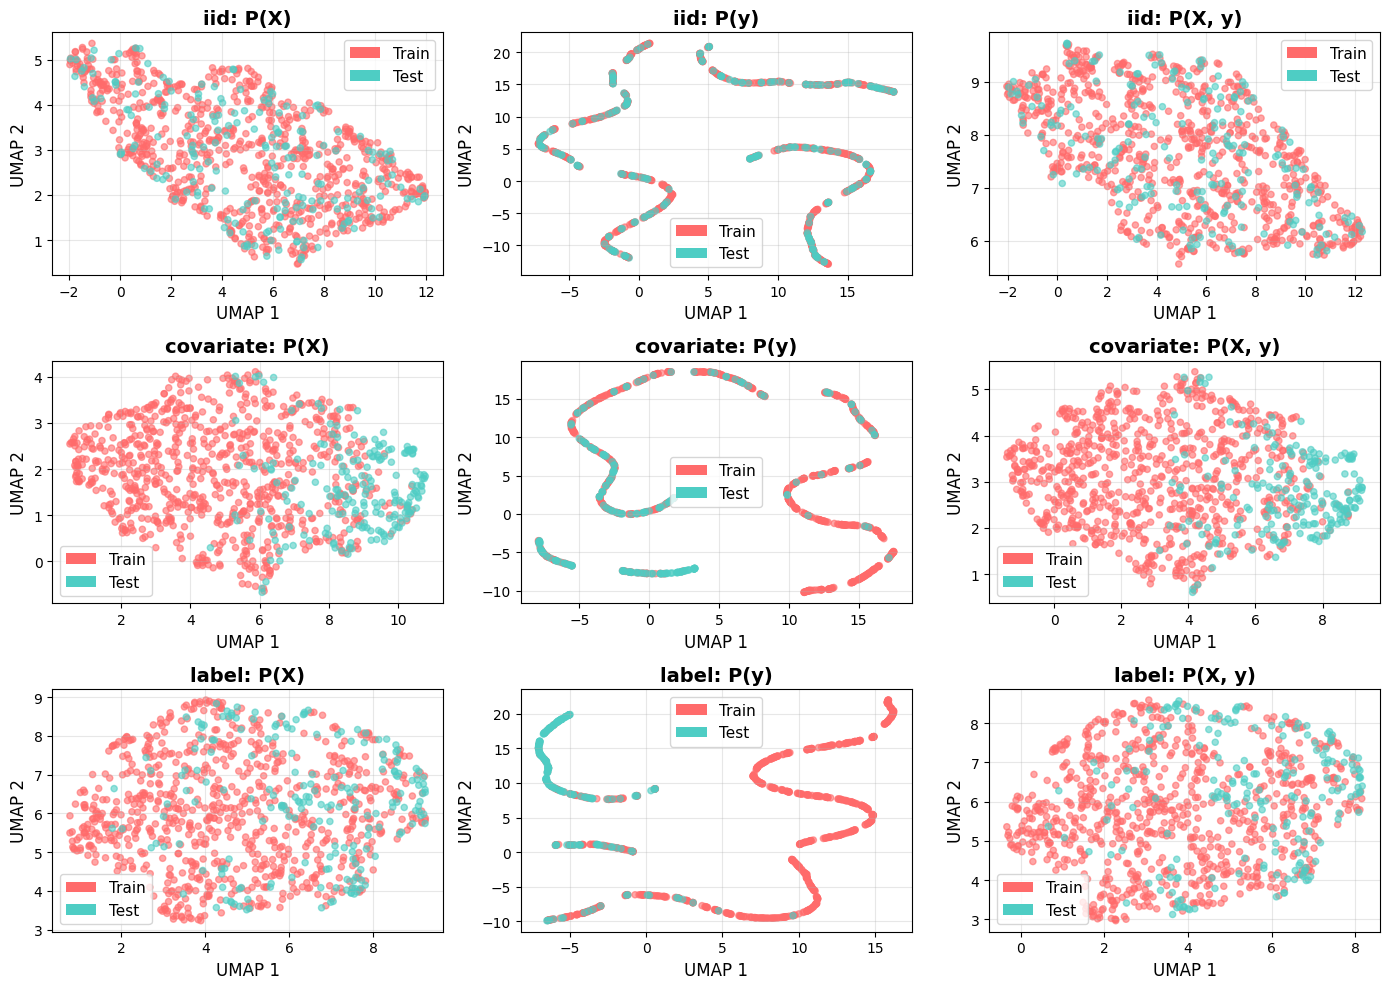

In [ ]:
# Visualize distribution differences
fig, axes = plt.subplots(3, 3, figsize=(14, 10))

for i, (name, data) in enumerate(example_datasets.items()):
    # Plot feature distribution
    plot_distributions(
        data['X_train'],
        data['X_test'],
        labels=('Train', 'Test'),
        ax=axes[i, 0],
        title=f"{name}: P(X)"
    )

    # Plot target distribution
    plot_distributions(
        data['y_train'].reshape(-1, 1),
        data['y_test'].reshape(-1, 1),
        labels=('Train', 'Test'),
        ax=axes[i, 1],
        title=f"{name}: P(y)"
    )

    # Plot joint distribution
    plot_distributions(
        np.hstack([data['X_train'], data['y_train'].reshape(-1, 1)]),
        np.hstack([data['X_test'], data['y_test'].reshape(-1, 1)]),
        labels=('Train', 'Test'),
        ax=axes[i, 2],
        title=f"{name}: P(X, y)"
    )

plt.tight_layout()
plt.show()


In [ ]:
# Quantify distribution differences using KS statistic
from scipy.stats import ks_2samp

for name, data in example_datasets.items():
    print(f"\n{name}:")

    # KS test for features (average over all features)
    feature_ks = []
    for j in range(data['X_train'].shape[1]):
        ks_stat, _ = ks_2samp(data['X_train'][:, j], data['X_test'][:, j])
        feature_ks.append(ks_stat)

    # KS test for target
    target_ks, _ = ks_2samp(data['y_train'], data['y_test'])

    print(f"  Average Feature KS statistic: {np.mean(feature_ks):.4f}")
    print(f"  Target KS statistic: {target_ks:.4f}")



iid:
  Average Feature KS statistic: 0.0600
  Target KS statistic: 0.0788

covariate:
  Average Feature KS statistic: 0.2764
  Target KS statistic: 0.4925

label:
  Average Feature KS statistic: 0.2469
  Target KS statistic: 0.7412


In [ ]:
# Visualize a DAG showing different feature types
# Using one of our datasets
example_name = 'covariate'
example_data = example_datasets[example_name]
adj_matrix = np.asarray(example_data['metadata']['adjacency_matrix'])

print(f"Number of nodes: {adj_matrix.shape[0]}")

parents = get_parents(adj_matrix)
children = get_children(adj_matrix)
spouses = get_spouses(adj_matrix)
mb_mask = example_data['metadata']['feature_mask']

print(f"\nParents: {np.where(parents)[0].tolist()}")
print(f"Children: {np.where(children)[0].tolist()}")
print(f"Spouses: {np.where(spouses)[0].tolist()}")
print(f"Markov Blanket: {np.where(mb_mask)[0].tolist()}")


Number of nodes: 20

Parents: [2, 3, 5, 7, 11, 12, 15, 18]
Children: [1, 8]
Spouses: [0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17]
Markov Blanket: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18]


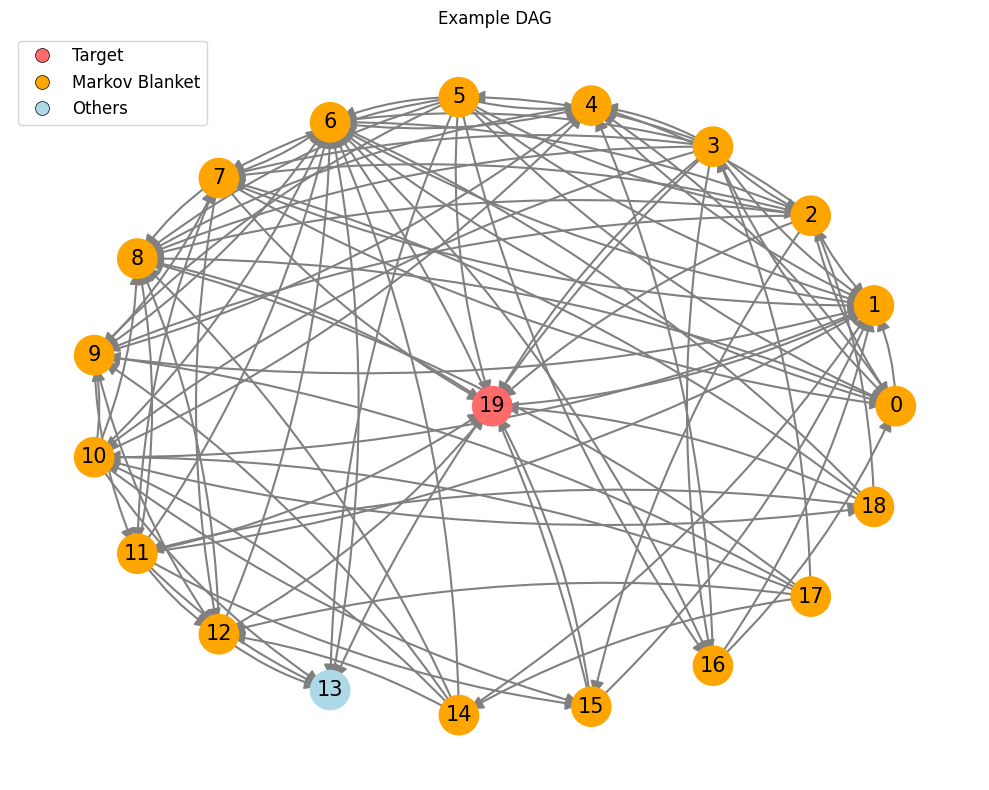

In [ ]:
# Visualize the DAG
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_graph(adj_matrix, ax=ax)
ax.set_title(f'Example DAG')
plt.tight_layout()
plt.show()


## 3. Optimality of Markov Blanket in OOD setting


We consider the following feature sets:

1. All Features
2. Markov Blanket
3. Parents (causal)
4. Children (anticausal)
5. P + C
6. Children + Spouses

These feature sets are tested across:
- Three environment types: IID, Covariate Shift, Label Shift
- Varying training sizes: 50 to 800, every 50 as a step
- Evaluation metric: Test MAE and STD (bias and variance)

Expected Outcome

- Nastl et al. show that all features outperforms parents and children consistently and by a large margin.


In [ ]:
def get_feature_sets(adj_matrix):
    """Get different feature selection masks."""
    n_features = adj_matrix.shape[0]
    feature_sets = {}

    feature_sets['All'] = np.ones(n_features, dtype=int)
    feature_sets['MB'] = get_markov_blanket(adj_matrix, -1)
    feature_sets['Parents'] = get_parents(adj_matrix, -1)
    feature_sets['Children'] = get_children(adj_matrix, -1)
    feature_sets['Parents+Children'] = feature_sets['Parents'] | feature_sets['Children']
    feature_sets['Children+Spouses'] = get_children(adj_matrix, -1) | get_spouses(adj_matrix, -1)

    # drop last element (target)
    for key in feature_sets:
        feature_sets[key] = feature_sets[key][:-1]
    return feature_sets


In [ ]:
def evaluate_feature_set(X_train, y_train, X_test, y_test, feature_mask):
    """Train and evaluate a model with selected features."""
    # Check if any features are selected
    assert np.any(feature_mask)

    # Train model
    results = linear_regression((X_train, y_train), (X_test, y_test), feature_mask)

    return results


In [ ]:
# Run comparison
train_sizes = list(range(50, 801, 50))
results = []

for env_name, data in datasets.items():

    adj_matrix = np.asarray(data['metadata']['adjacency_matrix'])

    X_train_full = data['X_train']
    y_train_full = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']

    for train_size in train_sizes:
        # Subsample training data
        X_train = X_train_full[:train_size]
        y_train = y_train_full[:train_size]

        # Get feature sets
        feature_sets = get_feature_sets(adj_matrix)

        # Evaluate each feature set
        for fs_name, fs_mask in feature_sets.items():
            metrics = evaluate_feature_set(X_train, y_train, X_test, y_test, fs_mask)

            results.append({
                'id': env_name,
                'Environment': env_name.split('-')[0],
                'Train Size': train_size,
                'Feature Set': fs_name,
                'RMSE': metrics['rmse'],
                'MAE': metrics['mae'],
                'STD': metrics['std'],
                'N Features': int(np.sum(fs_mask))
            })

results_df = pd.DataFrame(results)
print("\nEvaluation complete!")
results_df.head()



Evaluation complete!


,id,Environment,Train Size,Feature Set,RMSE,MAE,STD,N Features
0,iid-0,iid,50,All,0.535768,0.422666,0.521517,19
1,iid-0,iid,50,MB,0.454749,0.369088,0.448270,18
2,iid-0,iid,50,Parents,0.544163,0.429865,0.544481,9
3,iid-0,iid,50,Children,0.918191,0.729097,0.894237,3
4,iid-0,iid,50,Parents+Children,0.428410,0.347776,0.429287,12


In [ ]:
summary_df = results_df.groupby(['Environment', 'Feature Set', 'Train Size']).agg({
    'RMSE': 'mean',
    'MAE': 'mean',
}).reset_index()

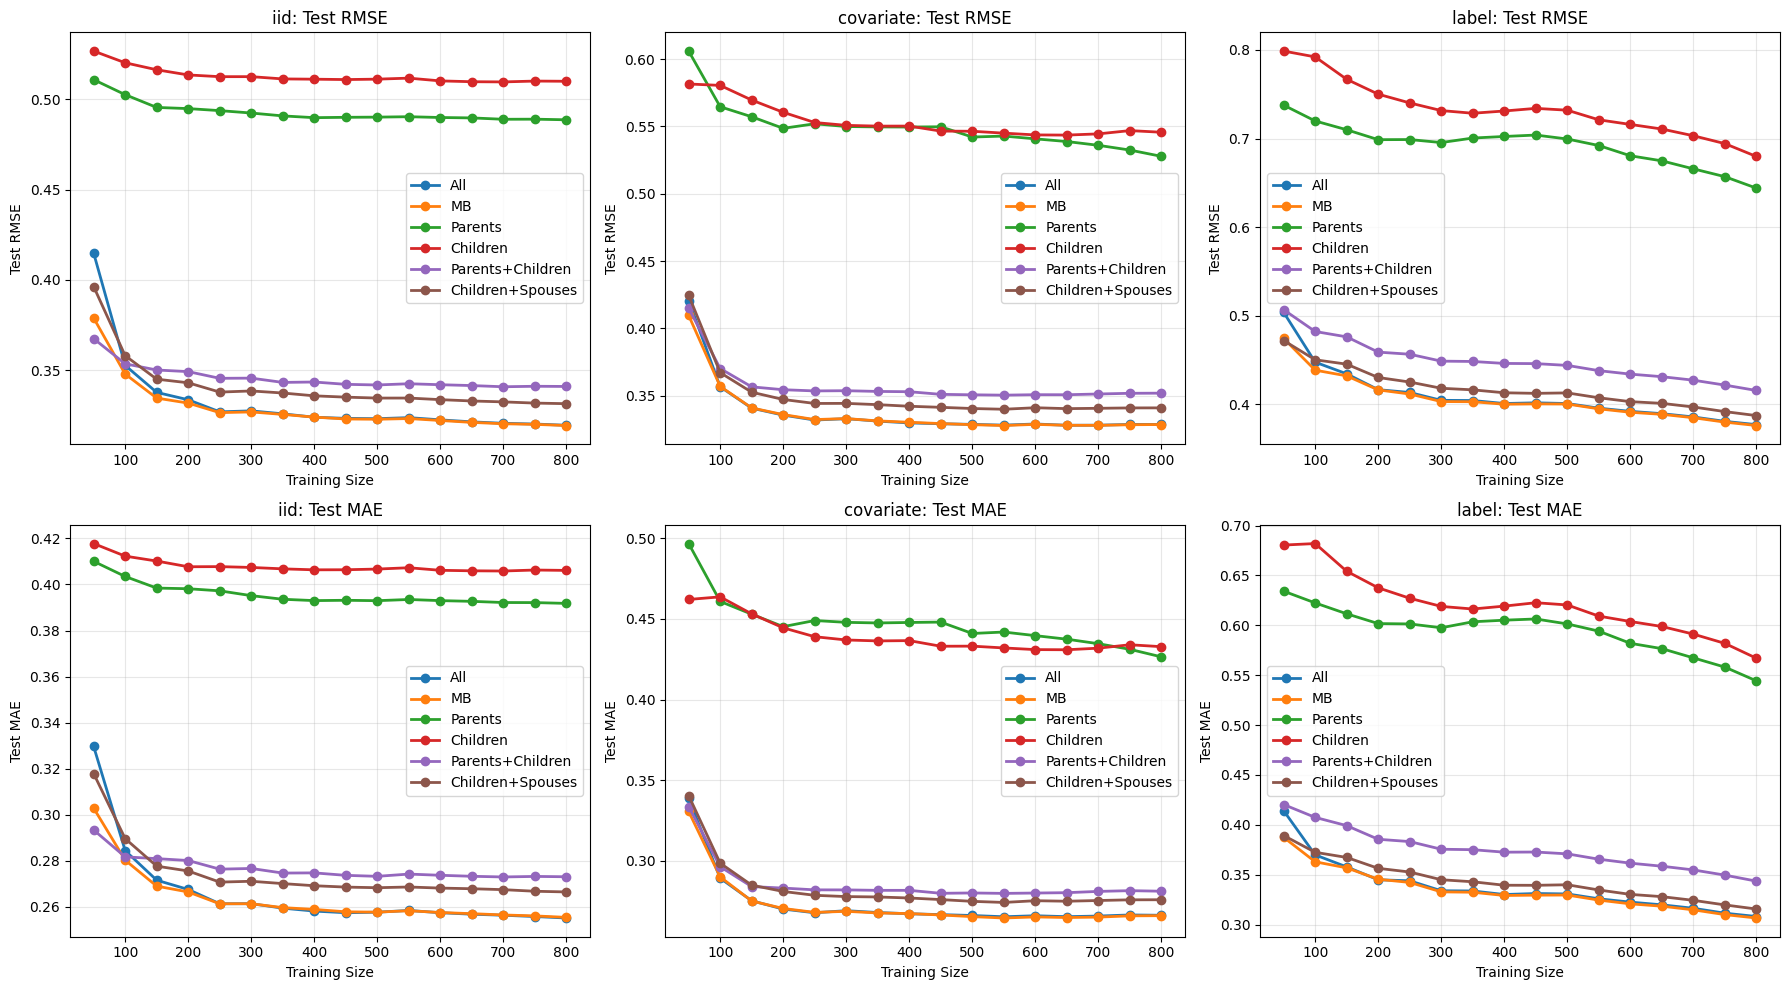

In [ ]:
# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, env_name in enumerate(['iid', 'covariate', 'label']):
    env_results = summary_df[summary_df['Environment'] == env_name]

    # Plot RMSE
    for fs_name in ['All', 'MB', 'Parents', 'Children', 'Parents+Children', 'Children+Spouses']:
        fs_results = env_results[env_results['Feature Set'] == fs_name]
        axes[0, i].plot(fs_results['Train Size'], fs_results['RMSE'],
                       marker='o', label=fs_name, linewidth=2)

    axes[0, i].set_xlabel('Training Size')
    axes[0, i].set_ylabel('Test RMSE')
    axes[0, i].set_title(f'{env_name}: Test RMSE')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

    # Plot MAE
    for fs_name in ['All', 'MB', 'Parents', 'Children', 'Parents+Children', 'Children+Spouses']:
        fs_results = env_results[env_results['Feature Set'] == fs_name]
        axes[1, i].plot(fs_results['Train Size'], fs_results['MAE'],
                       marker='o', label=fs_name, linewidth=2)

    axes[1, i].set_xlabel('Training Size')
    axes[1, i].set_ylabel('Test MAE')
    axes[1, i].set_title(f'{env_name}: Test MAE')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Key findings

1. MB is still the optimal feature set in OOD settings (at least covariate shift + label shift)
2. Parents and Children alone perform significantly worse than other feature sets. This is aligned with results in Nastl et. al
3. MB has significant lead when training size (<100) is limited, the gap diminishes as training size grows.
4. Due to the small graph size (node < 50) and relative large density, MB is often close to all features, making the difference less evident.

### References:

Nastl, Vivian, and Moritz Hardt. "Do causal predictors generalize better to new domains?." Advances in Neural Information Processing Systems 37 (2024): 31202-31315.

##Questions

Is MB still the optimal feature set for OOD prediction?



Based on the results from the Training Size vs Performance plots, the Markov Blanket (MB) is still the most effective feature set for OOD prediction, especially for covariate shift and label shift environments. When the training data is limited (for example, fewer than 100 samples), MB clearly outperforms all other feature sets, including All Features, Parents, Children, and combinations like Parents + Children. As the number of training samples increases, the performance gap between MB and All Features decreases which makes sense since the graphs used in this lab are relatively small and dense. This makes MB quite similar in size to the full feature set. This also makes the distinction less noticeable in larger training settings. Overall, across both covariate and label shift scenarios, MB consistently demonstrates better generalization under distribution shift compared to causally limited feature sets like Parents or Children alone. Therefore, MB remains the optimal feature selection strategy for OOD prediction within this experimental setup, particularly when training resources are limited.

## Bonus Point (5 Points)

1. Is MB still optimal for nonlinear functionals?

```python
example_meta = metadata_ds.filter(lambda x: sum(x['parents']) > 0 and sum(x['children']) > 0 and x['scm']['functional'] == 'nonlinear' and sum(x['feature_mask']) < x['n_features'])
```

In [ ]:
#1. Filter Nonlinear SCM Datasets
nonlinear_ds = metadata_ds.filter(
    lambda x: (
        x['scm']['functional'] == 'nonlinear' and
        sum(x['parents']) > 0 and
        sum(x['children']) > 0 and
        sum(x['feature_mask']) < x['n_features']
    )
)

print(f"Total nonlinear SCM datasets selected: {len(nonlinear_ds)}")
print(f"Example nonlinear metadata:\n{nonlinear_ds[0]['scm']}")


#  2. Load nonlinear datasets and evaluate feature sets
nonlinear_results = []

for entry in nonlinear_ds:
    data_id = entry["data_id"]
    env_name = entry["environment"]["method"]

    # Load dataset
    X_train, y_train, X_test, y_test, meta = load_data(
        path_to_data, data_id=data_id, include_metadata=True
    )

    adj_matrix = np.asarray(meta["adjacency_matrix"])
    feature_sets = get_feature_sets(adj_matrix)

    for train_size in train_sizes:
        X_tr = X_train[:train_size]
        y_tr = y_train[:train_size]

        for fs_name, fs_mask in feature_sets.items():
            if not np.any(fs_mask):
                continue

            metrics = evaluate_feature_set(X_tr, y_tr, X_test, y_test, fs_mask)

            nonlinear_results.append({
                "Data ID": data_id,
                "Environment": env_name,
                "Train Size": train_size,
                "Feature Set": fs_name,
                "MAE": metrics["mae"],
                "RMSE": metrics["rmse"],
                "STD": metrics["std"],
                "N Features": int(np.sum(fs_mask))
            })

nonlinear_df = pd.DataFrame(nonlinear_results)
print("\nNonlinear evaluation complete!")
nonlinear_df.head()


Filter:   0%|          | 0/120 [00:00<?, ? examples/s]

Total nonlinear SCM datasets selected: 21
Example nonlinear metadata:
{'coeff_range': 1.0, 'functional': 'nonlinear', 'noise_std': 0.5, 'seed': 57}

Nonlinear evaluation complete!


,Data ID,Environment,Train Size,Feature Set,MAE,RMSE,STD,N Features
0,data_015c212d,covariate,50,All,0.383793,0.501427,0.493476,19
1,data_015c212d,covariate,50,MB,0.381153,0.495619,0.485371,18
2,data_015c212d,covariate,50,Parents,0.412387,0.517680,0.513377,3
3,data_015c212d,covariate,50,Children,0.374192,0.478975,0.471609,12
4,data_015c212d,covariate,50,Parents+Children,0.353874,0.450460,0.451267,15


In [ ]:
nonlinear_summary = nonlinear_df.groupby("Feature Set")[["MAE", "RMSE", "STD"]].mean().round(4)
print("\n Nonlinear SCM Summary (Lower is better):")
print(nonlinear_summary)



🔎 Nonlinear SCM Summary (Lower is better):
                     MAE    RMSE     STD
Feature Set                             
All               0.4595  0.5646  0.4596
Children          0.5311  0.6393  0.4909
Children+Spouses  0.4625  0.5669  0.4585
MB                0.4572  0.5620  0.4571
Parents           0.5596  0.6628  0.4823
Parents+Children  0.4606  0.5618  0.4500


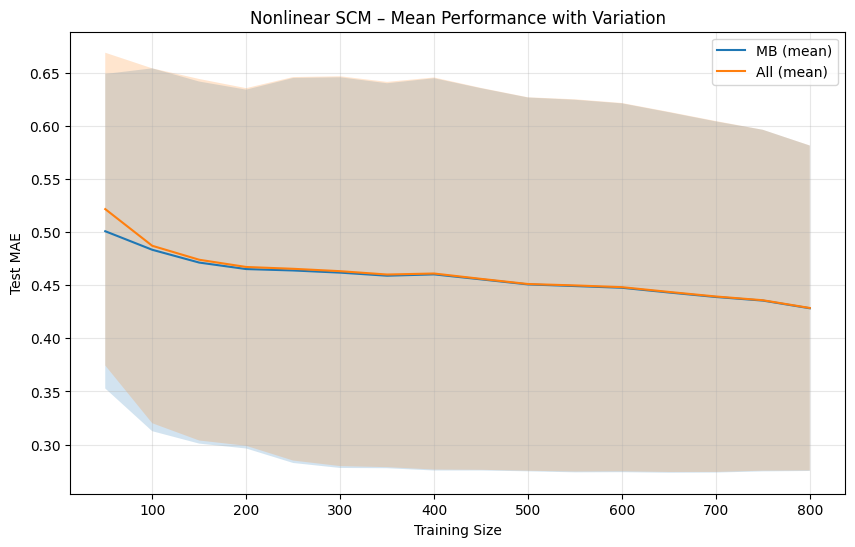

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame if it's a list
nonlinear_results = pd.DataFrame(nonlinear_results)

plt.figure(figsize=(10, 6))
for fs_name in ['MB', 'All']:
    grouped = nonlinear_results[nonlinear_results['Feature Set'] == fs_name].groupby('Train Size')
    means = grouped['MAE'].mean()
    stds = grouped['MAE'].std()

    plt.plot(means.index, means.values, label=f'{fs_name} (mean)')
    plt.fill_between(means.index, means - stds, means + stds, alpha=0.2)

plt.xlabel("Training Size")
plt.ylabel("Test MAE")
plt.title("Nonlinear SCM – Mean Performance with Variation")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

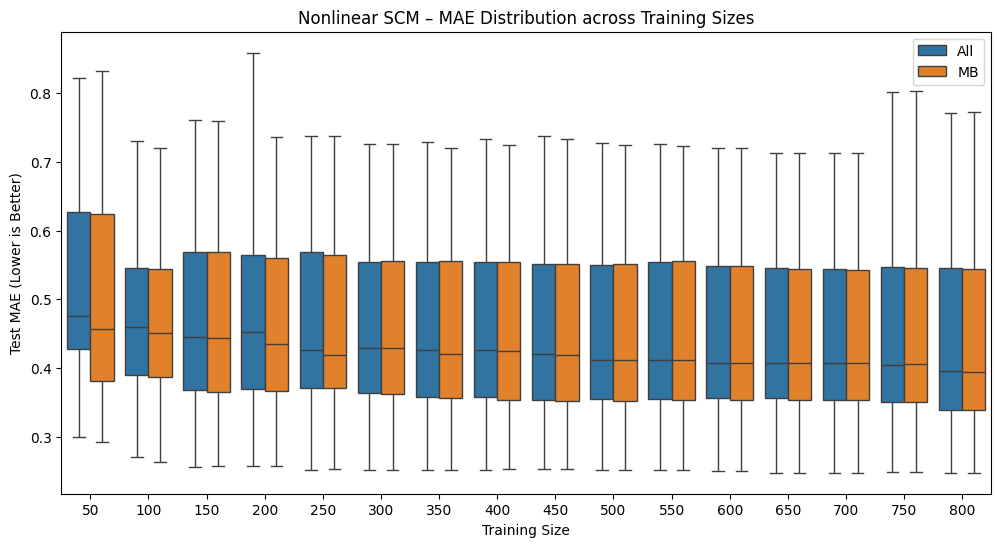

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 6))

sns.boxplot(
    x="Train Size", y="MAE",
    hue="Feature Set",
    data=nonlinear_results[nonlinear_results["Feature Set"].isin(["MB", "All"])],
    showfliers=False
)

plt.title("Nonlinear SCM – MAE Distribution across Training Sizes")
plt.xlabel("Training Size")
plt.ylabel("Test MAE (Lower is Better)")
plt.legend()
plt.show()

In [ ]:
mean_results = nonlinear_summary.groupby("Feature Set")[["MAE", "RMSE"]].mean()
best_feature = mean_results["MAE"].idxmin()
print(f"Best feature on average: {best_feature}")

Best feature on average: MB
